# **Imports**

In [ ]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 5.2 MB/s 


In [ ]:
from google.colab import drive 
import numpy as np
import pickle
import math
from sklearn.model_selection import train_test_split
from ignite.engine import Engine
from ignite.metrics import Accuracy

from sklearn import preprocessing


# PyTorch libraries and modules
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.cuda
torch.cuda.init()
cuda = torch.device('cuda')
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d , Conv2d, MaxPool2d,BatchNorm2d, Module, Softmax, BatchNorm1d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay

# **Load Dataset**

In [ ]:
drive.mount("/content/drive")
path = "/content/drive/MyDrive/RML2016.10b/RML2016.10b.dat"

Mounted at /content/drive


In [ ]:
with open(path, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

In [ ]:
print(p.keys())

dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('PAM4', 18), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('8PSK', -18), ('PAM4', -6), ('WBFM', -18), ('BPSK', 8), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('AM-DSB', -18), ('QPSK', 8), ('PAM4', 14), ('WBFM', -8), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('8PSK', -10), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('WBFM', -14), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('QAM16', 8), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('WBFM', 10), ('BPSK', -20), ('PAM4', 4), ('GFSK', 10), ('QAM16', -6), ('QAM64', 4), ('PAM4', -20), ('8PSK', 10), ('QAM64', -10), (

In [ ]:
p['CPFSK', 16].shape

(6000, 2, 128)

In [ ]:
print(p['CPFSK', 16])

[[[-8.4336055e-03 -7.4529098e-03 -6.5865787e-03 ...  5.8436426e-03
    6.4632334e-03  7.7720531e-03]
  [-3.0449990e-03 -4.4847154e-03 -5.8819586e-03 ...  2.8013648e-03
    1.6313108e-03  1.9426958e-03]]

 [[ 5.1456993e-03  3.9467127e-03  3.1666001e-03 ...  7.6177912e-03
    6.9069103e-03  6.0117044e-03]
  [-4.3870406e-03 -5.3037172e-03 -6.0104853e-03 ...  3.8679331e-03
    5.0076349e-03  6.2285536e-03]]

 [[-3.0032482e-03 -1.5474415e-03  9.8395958e-06 ... -6.6704229e-03
   -5.7166354e-03 -4.7606654e-03]
  [-7.9068402e-03 -8.1802756e-03 -8.2536871e-03 ... -4.8993239e-03
   -6.0974243e-03 -7.1471981e-03]]

 ...

 [[-8.8934284e-03 -7.0061348e-03 -5.5192257e-03 ... -7.2657885e-03
   -7.5627132e-03 -7.0539610e-03]
  [ 2.0400684e-03  3.3344433e-03  5.0496161e-03 ... -1.1637282e-03
    2.1522508e-04  1.6901256e-03]]

 [[ 8.0783647e-03  7.6847030e-03  6.7839944e-03 ...  6.5089697e-03
    6.3169380e-03  5.6353081e-03]
  [ 1.7798715e-03  3.2191949e-03  4.8732162e-03 ... -1.4278805e-03
   -2.7564

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], p.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(p[(mod,snr)])
        for i in range(p[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)



> Waveform Array




In [ ]:
print(X.shape)

(1200000, 2, 128)




> Different Labels(Modulations)



In [ ]:
print(set(np.array(lbl)[:,0]))

{'QAM64', 'QPSK', 'QAM16', 'AM-DSB', '8PSK', 'BPSK', 'CPFSK', 'PAM4', 'GFSK', 'WBFM'}


In [ ]:
y = np.array(lbl)



> Encode labels to integers



In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y[:,0])
y = le.transform(y[:,0])
y_new=[]
for i in range(len(y)):
  y_new.append([y[i],lbl[i][1]])

In [ ]:
y=np.array(y_new)

In [ ]:
print(y.shape)

(1200000, 2)


# **Split Dataset**

In [ ]:
x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=lbl)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=1/6, test_size=5/6,stratify=y_rem)

# **Reshape Dataset**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1],x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0],1,x_val.shape[1],x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1],x_test.shape[2])

In [ ]:
def run_model(model,optimizer,dataloader,val_dataloader,train = True):
  accuracy = Accuracy()
  if torch.cuda.is_available():
         device = "cuda"
  else:
        device = "cpu"
  model = model.cuda()
  if train:
    model.train()
  loss = nn.CrossEntropyLoss()
  total_loss = 0
  for data,label in dataloader:
    data = data.to(cuda)
    optimizer.zero_grad()
    label = label.type(torch.LongTensor)
    label = label.to(cuda)
    output = model(data)
    # print("Output",output)
    # print("Label",label)
    loss_ = loss(output, label)
    total_loss += loss_.item()
    loss_.backward()
    optimizer.step()
    accuracy.update((output,label))
    torch.cuda.empty_cache()

  
  model.eval()
  accuracy_val = Accuracy()
  total_lossVal = 0
  for data , label in val_dataloader:
    data = data.to(cuda)
    label = label.type(torch.LongTensor)
    label = label.to(cuda)
    output = model(data)
    loss_ = loss(output, label)
    total_lossVal += loss_.item()
    accuracy_val.update((output,label))
    torch.cuda.empty_cache()
  return accuracy.compute(),accuracy_val.compute(),total_loss/len(dataloader),total_lossVal/len(val_dataloader)

In [ ]:
## first class for reflecting dataset  
class myDataset(Dataset):
  def __init__(self, array, label):
    self.array = array
    self.label = label

  def __getitem__(self, index):
    #takes index and return trainig example and its label

    return torch.tensor(self.array[index], dtype=torch.float),torch.tensor(self.label[index],dtype=torch.int)
  def __len__(self):
    #returns number of examples
    return len(self.array)

In [ ]:
def train(model,epochs=1):
  dataset = myDataset(x_train,y_train[:,0])
  dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
  val_dataset = myDataset(x_val,y_val[:,0])
  val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
  optimizer = torch.optim.Adam(model.parameters(), 0.001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=.1, threshold=1e-4)
  epochs_list=[]
  validation_losses=[]
  training_losses=[]
  training_accuracies=[]
  validation_accuracies=[]
  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}\n-------------------------------")
      accuracy,accuracy_val,loss,loss_val = run_model(model,optimizer,dataloader,val_dataloader)
      #scheduler.step(loss_val)
      epochs_list.append(epoch+1)
      validation_losses.append(loss_val)
      training_losses.append(loss)
      validation_accuracies.append(accuracy_val)
      training_accuracies.append(accuracy)
      print(f"Training Loss: {loss}")
      print(f"Training Accuracy: {accuracy*100}")
      print(f"Validation Loss: {loss_val}")
      print(f"Validation Accuracy: {accuracy_val*100}")
      print("-------------------------------")
  plt.plot(epochs_list,training_accuracies)
  plt.plot(epochs_list,validation_accuracies)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training vs Validation Accuracies')
  plt.legend(['Training','Validation'])
  plt.show()
  plt.plot(epochs_list,training_losses)
  plt.plot(epochs_list,validation_losses)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training vs Validation Losses')
  plt.legend(['Training','Validation'])
  plt.show()

In [ ]:
def test(model,x_snr,y_snr,plot=False):
  test_dataset = myDataset(x_snr,y_snr[:,0])
  test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)
  model.eval()
  test_accuracy = Accuracy()
  test_loss = 0
  y_predict=[]
  loss = nn.CrossEntropyLoss()
  for data , label in test_dataloader:
    data = data.to(cuda)
    label = label.type(torch.LongTensor)
    label = label.to(cuda)
    output = model(data)
    for tensor_value in output:
          y_predict.append(torch.argmax(tensor_value).data.cpu().numpy())
    loss_ = loss(output, label)
    test_loss += loss_.item()
    test_accuracy.update((output,label))
    torch.cuda.empty_cache()
  y_predict=np.array(y_predict)
  accuracy=accuracy_score(y_snr[:,0],y_predict)
  if plot==True:
    print(f'Test Accuracy:{accuracy}')
    print(f'Test Loss:{test_loss/len(test_dataloader)}')
    print(f'Accuracy Report:\n{classification_report(y_snr[:,0],y_predict)}')
    cm = confusion_matrix(y_snr[:,0], y_predict)
    classes =  ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.title('Confusion Matrix')
    disp.plot(ax=ax,cmap=plt.cm.Blues)
    plt.show()
  return accuracy

In [ ]:
def test_snrs(model):
  snrs=[]
  for i in range(-20,20,2):
    snrs.append(i)
  snrs_x=dict()
  snrs_y=dict()
  for snr in snrs:
     snrs_x[snr]=[]
     snrs_y[snr]=[]
  for i in range(len(y_test)):
     snr=y_test[i][1]
     snrs_x[snr].append(x_test[i])
     snrs_y[snr].append(y_test[i])
  accuracies=[]
  accuracy_sum=0
  for snr in snrs:
    if snr==0:
      accuracy=test(model,np.array(snrs_x[snr]),np.array(snrs_y[snr]),plot=True)
    else:
      accuracy=test(model,np.array(snrs_x[snr]),np.array(snrs_y[snr]))
    accuracy_sum+=accuracy
    accuracies.append(accuracy)
  print('\n\n\n')
  plt.plot(snrs,accuracies)
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Accuracy for each SNR')
  plt.show()
  print(f'\n\n\nAverage Accuracy:{accuracy_sum/len(snrs)}')


In [ ]:
from torchsummary import summary
class CNNModel(Module):   
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = Conv2d(1, 64, kernel_size=(2,2), stride=1).to(cuda)

        self.conv2 = Conv2d(64, 16, kernel_size=(1,1), stride=1).to(cuda)

        self.fc1 = Linear(2032,128).to(cuda)

        self.fc2 = Linear(128,11).to(cuda)
   

    # Defining the forward pass    
    def forward(self, x):
        x = self.conv1(x).to(cuda)
        x = F.relu(x).to(cuda)

        x = self.conv2(x).to(cuda)
        x = F.relu(x).to(cuda)

        x = torch.flatten(x,1).to(cuda)

        x = self.fc1(x).to(cuda)
        x = F.relu(x).to(cuda)
        x = self.fc2(x).to(cuda)
        x = F.log_softmax(x,dim=1).to(cuda)

                
        return x

In [ ]:
model = CNNModel()
BATCH_SIZE = 32
summary(model, (  1, 2, 128),BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 1, 127]             320
            Conv2d-2           [32, 16, 1, 127]           1,040
            Linear-3                  [32, 128]         260,224
            Linear-4                   [32, 11]           1,419
Total params: 263,003
Trainable params: 263,003
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 2.51
Params size (MB): 1.00
Estimated Total Size (MB): 3.55
----------------------------------------------------------------


Epoch 1
-------------------------------
Training Loss: 1.7104479225544702
Training Accuracy: 33.06202380952381
Validation Loss: 1.508261495145162
Validation Accuracy: 40.28666666666666
-------------------------------
Epoch 2
-------------------------------
Training Loss: 1.431450179174968
Training Accuracy: 42.99464285714286
Validation Loss: 1.3689701726913452
Validation Accuracy: 45.14333333333334
-------------------------------
Epoch 3
-------------------------------
Training Loss: 1.2945856958911532
Training Accuracy: 47.037261904761905
Validation Loss: 1.271022610537211
Validation Accuracy: 47.596666666666664
-------------------------------
Epoch 4
-------------------------------
Training Loss: 1.238790795737221
Training Accuracy: 48.70107142857143
Validation Loss: 1.2514350358963013
Validation Accuracy: 48.693333333333335
-------------------------------
Epoch 5
-------------------------------
Training Loss: 1.2201959126199995
Training Accuracy: 49.360952380952384
Validation Loss: 

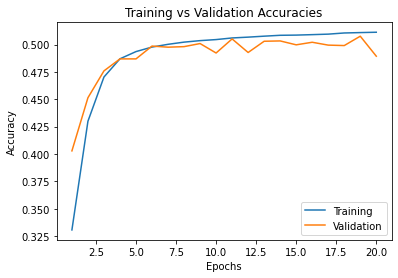

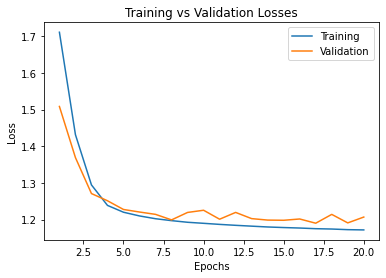

In [ ]:
train(model,epochs=20)

Test Accuracy:0.6734666666666667
Test Loss:0.6473803923074116
Accuracy Report:
              precision    recall  f1-score   support

           0       0.48      0.26      0.34      1500
           1       0.59      0.82      0.69      1500
           2       0.89      0.87      0.88      1500
           3       0.85      0.89      0.87      1500
           4       0.93      0.91      0.92      1500
           5       0.96      0.94      0.95      1500
           6       0.47      0.52      0.50      1500
           7       0.54      0.43      0.48      1500
           8       0.43      0.64      0.51      1500
           9       0.63      0.45      0.52      1500

    accuracy                           0.67     15000
   macro avg       0.68      0.67      0.67     15000
weighted avg       0.68      0.67      0.67     15000



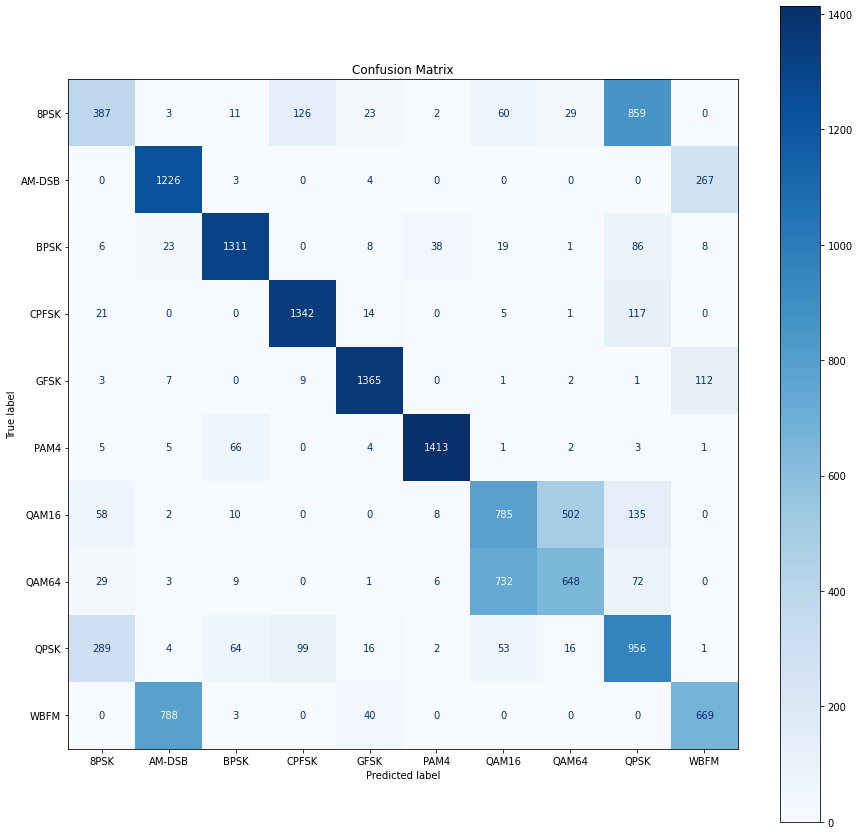

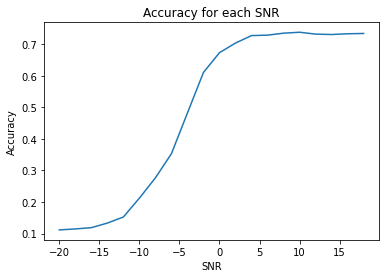




Average Accuracy:0.49024


In [ ]:
test_snrs(model)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda) 
        out, _ = self.rnn(x, h0)  
        out = out[:, -1, :]         
        out = self.fc(out)
        return out

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_val = x_val.reshape(x_val.shape[0],x_val.shape[2],x_val.shape[3])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [ ]:
sequence_length = 28
hidden_size = 128
num_layers = 2
input_size= 128
num_classes=11
model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(cuda)
summary(model, (2, 128),BATCH_SIZE)

In [ ]:
train(model,epochs=20)

In [ ]:
test_snrs(model)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(cuda)   
        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
sequence_length = 28
hidden_size = 128
num_layers = 2
input_size= 128
num_classes=11
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(cuda)


In [ ]:
train(model,epochs=20)

Test Accuracy:0.5068666666666667
Test Loss:1.1762995548339794
Accuracy Report:
              precision    recall  f1-score   support

           0       0.31      0.40      0.35      1500
           1       0.54      0.31      0.40      1500
           2       0.68      0.71      0.69      1500
           3       0.62      0.48      0.54      1500
           4       0.65      0.78      0.70      1500
           5       0.91      0.77      0.83      1500
           6       0.31      0.54      0.39      1500
           7       0.49      0.22      0.30      1500
           8       0.35      0.19      0.24      1500
           9       0.45      0.67      0.54      1500

    accuracy                           0.51     15000
   macro avg       0.53      0.51      0.50     15000
weighted avg       0.53      0.51      0.50     15000



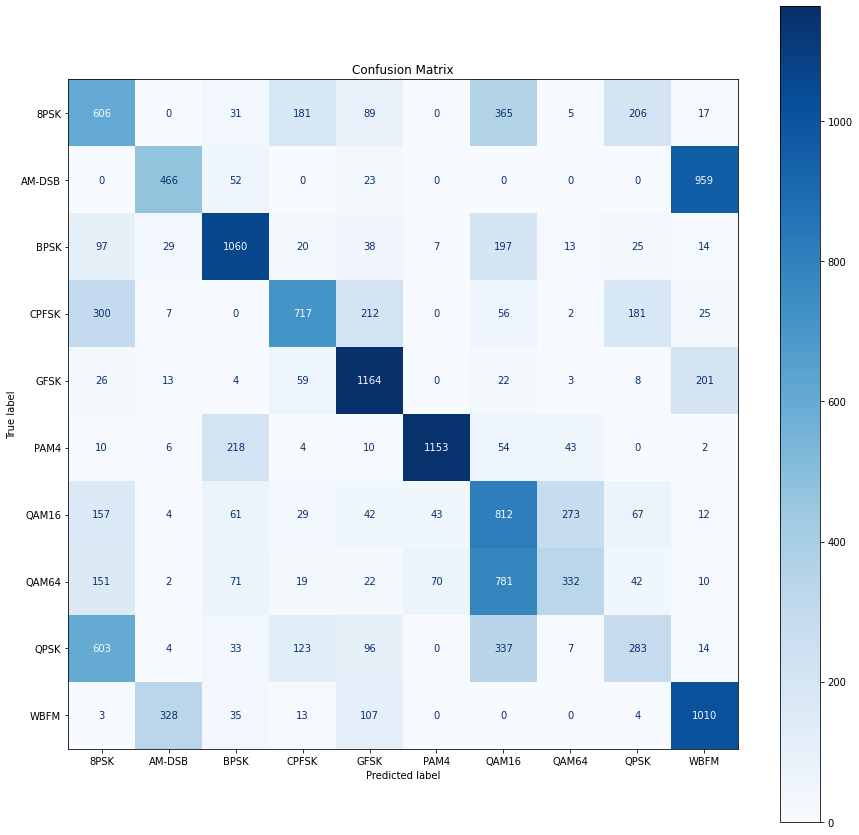

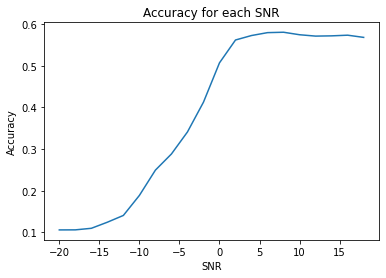

Average Accuracy:0.3863333333333333


In [ ]:
test_snrs(model)